In [4]:
import os
import sys
sys.path.append('/Users/ahakso/secondmeasure/consumer-enrichment/')

In [5]:
from consumer_enrichment.util.notebook import run_query
pd.options.display.max_rows = 1000

In [8]:
locations_table = "production.rp1.locations_jun_2020"
descriptors_table = 'production.rp1.descriptors_jun_2020'
dp1_transactions_table = "production.dp1_4m_v61_daily.transactions_latest"


# Approach
Start with dominos

The 2020Q3 filings says thaty have 6239 US stores

### RP1
group by city, state and merchant id, then count distinct merchant id

### DP4
group by city, state and hashed address, then count distinct address


later, group by city, state and hashed address, then get first and last seen date for that merchant_xid

# RP1

In [12]:
# correctly selects 4 dominos in SF
run_query(f'''
select *
from {locations_table}
where state_province_code = 'CA'
and regexp_like(city_name,'^SAN FR?ANCISCO')
and regexp_like(merchant_name,'DOMINO.?S')
limit 100
''')

,merchant_market_hierarchy_id,merchant_name,merchant_name_cleansed,address,address_cleansed,city_name,city_name_cleansed,state_province_code,state_province_code_cleansed,postal_code,postal_code_cleansed,country_code,country_code_cleansed,latitude,longitude,...,phone_number_cleansed,merchant_category_code,legal_corporate_name,legal_corporate_name_cleansed,aggregate_merchant_id,aggregate_merchant_name,key_aggregate_merchant_id,parent_aggregate_merchant_id,parent_aggregate_merchant_name,msa_code,naics_code,dma_code,industry,super_industry,dun_bradstreet_number
0,324756296,8421 DOMINOS PIZZA,DOMINO'S PIZZA,5200 GEARY BLVD,5200 GEARY BLVD STE D,SAN FRANCISCO,SAN FRANCISCO,CA,CA,94118,94118-2818,USA,USA,37.780818,-122.475882,...,(415) 387-3030,5814,TEAM SAN FRANCISCO PIZZA LLC,TEAM SAN FRANCISCO PIZZA LLC,18932,DOMINO'S PIZZA (NSR),10360,10360,DOMINO'S PIZZA,None,722211,807,EAP,ACF,NaN
1,324756298,8134 DOMINOS PIZZA,DOMINO'S,320 BAY SHORE BLVD,320 BAY SHORE BLVD,SAN FRANCISCO,SAN FRANCISCO,CA,CA,94124,94124-1507,USA,USA,37.742760,-122.405790,...,4156478400,5814,TEAM GOLDEN GATE,TEAM GOLDEN GATE,18932,DOMINO'S PIZZA (NSR),10360,10360,DOMINO'S PIZZA,None,722211,807,EAP,ACF,NaN
2,324788960,DOMINO'S 7764,DOMINO'S PIZZA,876 GEARY ST,876 GEARY ST,SAN FRANCISCO,SAN FRANCISCO,CA,CA,94109,94109-7228,USA,USA,37.786313,-122.417625,...,(415) 776-0400,5814,TEAM SAN FRANCISCO PIZZA LLC,TEAM SAN FRANCISCO PIZZA LLC,18932,DOMINO'S PIZZA (NSR),10360,10360,DOMINO'S PIZZA,None,722211,807,EAP,ACF,NaN
3,459690142,8418 DOMINOS PIZZA,DOMINO'S PIZZA,3116 NORIEGA ST,3116 NORIEGA ST,SAN FRANCISCO,SAN FRANCISCO,CA,CA,94122,94122-4046,USA,USA,37.753455,-122.497135,...,4156818100,5814,NFG SAN FRANCISCO LLC,TEAM GOLDEN GATE,10360,DOMINO'S PIZZA,10360,10360,DOMINO'S PIZZA,None,722211,807,EAP,ACF,556971476.0


In [39]:
# city/state dominos counts
rp1_dominos_counts = run_query(f'''
select
city_name_cleansed || ', ' || state_province_code_cleansed location
, count(*) as n_dominos
from {locations_table}
where regexp_like(merchant_name_cleansed,'DOMINO''?S ?(PIZZA|\d{3}|$)')
group by 1
''')

In [38]:
# confirm descriptions looks okay
regex_matches = run_query(f'''
select merchant_name_cleansed, count(*) as description_counts
from {locations_table}
where regexp_like(merchant_name_cleansed,'DOMINO''?S ?(PIZZA|\d{3}|$)')
group by merchant_name_cleansed
limit 10000
''')

In [43]:
# seeing ~an 8% overshoot in merchant counts compared to ground truth
print(rp1_dominos_counts.n_dominos.sum())
rp1_dominos_counts.n_dominos.sum()/6239-1

6722


0.07741625260458407

In [44]:
rp1_state_location_counts = run_query(f'''
select
state_province_code_cleansed location
, count(*) as n_dominos
from {locations_table}
where regexp_like(merchant_name_cleansed,'DOMINO''?S ?(PIZZA|\d{3}|$)')
group by 1
''')

rp1_state_location_counts.sort_values('location')

# DP4

## Get Dominos counts under various conditions
tl;dr is that we still overshoot, a bit more with dp4 than rp1

In [70]:
# dp4_transactions_table = "scratch.dp4_anon.windcharger_20210604_10k"
dp4_transactions_table = "scratch.dp4_anon.windcharger_20210604"
dates = ['2020-06-01','2020-09-30']
dp4_filters = '''dp4_transaction_type_cd in (
    'B',   -- merchandise with cashback
    'M',   -- merchandise
    'N',   -- bill payment (non-recurring)
    'Q',   -- quasi-cash, includes coinbase, online gambling etc
    'U',   -- recurring charge/fee (investigate further)
    'Z'    -- completion of pre-auth (P)
    )
and dp4_transaction_iso_currency_xcd = '840'  -- require USD
and (dp4_merchant_country_xcd = '840'  -- require US based merchants
    or dp4_merchant_country_xcd is null
    or dp4_merchant_country_xcd = 'nan'
    or dp4_merchant_country_xcd = '000'
    )
and (dp4_country_xcd = '840'     -- require US based consumers
    or dp4_country_xcd is null
    or dp4_country_xcd = 'nan'
    or dp4_country_xcd = '000'
    )
and dp4_transaction_amt > 0  
'''

In [72]:
dp4_dominos_counts = run_query(f'''
select 
geo_city || ', ' || geo_state as location
, count(distinct dp4_merchant_xid) as n_dominos
from {dp4_transactions_table}
where regexp_like(vendor_matched_vendors,'^DPZ:')
and raw_file_date between '{dates[0]}' and '{dates[1]}'
and {dp4_filters}
group by 1
order by 2
''')

In [73]:
dp4_dominos_counts.n_dominos.sum()

12319

In [75]:
run_query(f'''
select 
distinct dp4_merchant_xid as n_dominos
from {dp4_transactions_table}
where regexp_like(vendor_matched_vendors,'^DPZ:')
and raw_file_date between '{dates[0]}' and '{dates[1]}'
''')

,n_dominos
0,42da515a36c463b4ed86a6d46749a41f
1,f0db0634a04ca32858cb5e2fd4bab249
2,b117cd77726bbd20cc6e86d786f8b86e
3,454885cbca886c011a8e38c6a746c059
4,debf178f1ff821ca86b116d0f631041e
...,...
7852,fd698ad2dc23cdf9b73231d8d2ffb862
7853,b2adddb88beaee1d0eb4298854aa12af
7854,9b87cea45ded2d175454a0643ec1dba2
7855,c96eb83cbe6ce5f90f9518f10ed82ac5


In [74]:
run_query(f'''
select 
distinct dp4_merchant_xid as n_dominos
from {dp4_transactions_table}
where regexp_like(vendor_matched_vendors,'^DPZ:')
and raw_file_date between '{dates[0]}' and '{dates[1]}'
and {dp4_filters}
''')

,n_dominos
0,61beafb8a1c428ea0525e298f30eda48
1,b3d7c265c6ea751832c814c2991fba17
2,a6817b39912471d5bce01fb049cdcfb7
3,eccde96f578a4de644f499a65e9fbd33
4,4d5f35d61700aee75c0507792cc7241e
...,...
7216,f662a776ee7787e8a3dfdc9df2f33c3a
7217,ba51d7e56d18142145aa072395b25b10
7218,ba26f365ab112ed7591e76fde68238fa
7219,7fd89d7f524e43e7d8f46162f149f862


In [80]:
n_by_month = run_query(f'''
select 
date_trunc('month', date(raw_file_date)) as month
, count(distinct dp4_merchant_xid) as n
from {dp4_transactions_table}
where regexp_like(vendor_matched_vendors,'^DPZ:')
--and raw_file_date between '{dates[0]}' and '{dates[1]}'
and {dp4_filters}
group by 1
order by 1
''',date_cols=['month'])

,month,n
0,2017-01-01,5674
1,2017-02-01,5644
2,2017-03-01,5727
3,2017-04-01,5702
4,2017-05-01,5746
5,2017-06-01,5756
6,2017-07-01,5813
7,2017-08-01,5788
8,2017-09-01,5810
9,2017-10-01,5859


<AxesSubplot:xlabel='month'>

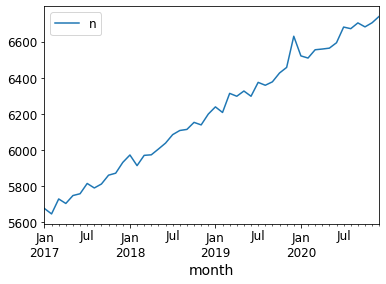

In [81]:
n_by_month.plot(x='month',y='n')

In [82]:
n_by_month.max()

month    2020-12-01 00:00:00
n                       6741
dtype: object

# Calculate fraction of active sales days in a given city that are active. (sql + python)

Just realizing - could do this based on sales instead of days. Indicator variable for whether or not a store is active, then sum sales. 

In [335]:
dp4_transactions_table = "scratch.dp4_anon.windcharger_20210604"
cte = {}
cte['merchant_first_last'] = f"""merchant_first_last as
    (select dp4_merchant_xid
    , min(raw_transaction_date) as first_seen
    , max(raw_transaction_date) as last_seen
    from {dp4_transactions_table}
    where regexp_like(vendor_matched_vendors,'^DPZ:')
    --and raw_file_date between '{dates[0]}' and '{dates[1]}'
    and {dp4_filters}
    group by 1
    )"""

cte["mode_city"] = f""" mode_city as (
    select dp4_merchant_xid, location 
    from (
        select 
        dp4_merchant_xid
        , geo_city || ', ' || geo_state as location
        , ROW_NUMBER() OVER (PARTITION BY dp4_merchant_xid ORDER BY COUNT(*) DESC) as seq
        from {dp4_transactions_table} t
        where geo_city is not null
        and geo_state is not null
        group by 1, 2
    )
    where seq = 1
    )"""

cte["city_merchant_first_last"] = f""" city_merchant_first_last as (
    select 
    dp4_merchant_xid
    , first_seen
    , last_seen
    , location 
    from merchant_first_last
    join mode_city using(dp4_merchant_xid)
    )
    """


cte["fiscal_quarters"] = f''' fiscal_quarters as (
    select
    company
    , quarter_start_date
    , quarter_end_date
    from bloomberg_revenue_and_estimates.v1_0_data
    where company = 'DPZ'
    and version = (select max(version) from bloomberg_revenue_and_estimates.v1_0_data)
    and quarter_start_date >= date('2017-01-01')
    order by company, quarter_start_date
    )
    '''

cte['merchant_location_fq'] = f'''merchant_location_fq as (
    select 
    location 
    , dp4_merchant_xid
    , first_seen
    , last_seen
    , quarter_start_date
    , quarter_end_date
    from merchant_first_last d
    join mode_city m using(dp4_merchant_xid)
    join fiscal_quarters q
    on first_seen <= quarter_end_date
      and last_seen >= quarter_start_date
      order by location, quarter_start_date)
      '''

In [352]:
cmd = f"""
with {cte['merchant_first_last']}
, {cte['mode_city']}
, {cte['city_merchant_first_last']}
select * from city_merchant_first_last
limit 10
"""
first_seen_last_seen = run_query(
    cmd, date_cols=["first_seen", "last_seen"]
)

In [353]:
first_seen_last_seen

,dp4_merchant_xid,first_seen,last_seen,location
0,b6889c01a913ca34f03bdca792a0a630,2017-01-02,2020-12-31,"Park Ridge, IL"
1,cd1004b0ad68adf61f8fa44b300b344c,2017-01-03,2020-12-30,"Columbia, SC"
2,a8607661b035b1b23e9450292e7c4484,2019-11-07,2020-12-30,"Linden, NJ"
3,7c543a419c239f94e4ec55f33cccc9b2,2019-03-07,2020-12-31,"Zephyrhills, FL"
4,dbd99c7146533db03701204919d6872b,2017-01-13,2020-12-31,"Kingwood, TX"
5,c1fc9766217f034134e229dcadcf9663,2017-04-05,2020-12-24,"New City, NY"
6,80c7c1512d730d48b0c275424bdad178,2017-01-01,2020-12-31,"Maysville, KY"
7,e91d19e55cc55e200b63ac8b9e714e35,2017-03-02,2020-12-30,"Gainesville, GA"
8,3d55445638743b809331948bbd185fb3,2017-01-03,2020-12-31,"Grand Terrace, CA"
9,c726e8be2d4311d1adb25c99e5a0144b,2019-02-22,2020-12-25,"Las Cruces, NM"


[Text(0.5, 0, 'years open'),
 Text(0, 0.5, 'n stores'),
 Text(0.5, 1.0, 'history')]

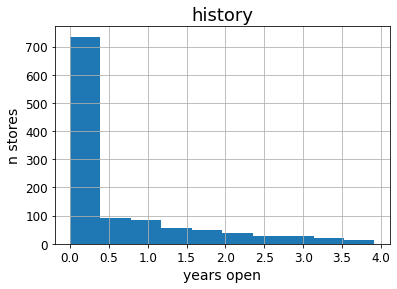

In [170]:
first_seen_last_seen = first_seen_last_seen.assign(years_seen=lambda x: (x.last_seen-x.first_seen).dt.days/365)
first_seen_last_seen.years_seen.hist()
plt.gca().set(xlabel='years open',ylabel='n stores',title='history')

In [168]:
first_seen_last_seen.loc[first_seen_last_seen.days_seen.idxmax(),:]

dp4_merchant_xid     e94ea2dca900a13adef6c745bfe4d216
first_seen                        2017-01-05 00:00:00
first_established                 2018-01-05 00:00:00
last_seen                         2020-12-05 00:00:00
location                              Crown Point, IN
days_seen                                    3.917808
Name: 1093, dtype: object

In [258]:
def calc_days_active(row: pd.Series):
    start_date = row.loc[["first_seen", "quarter_start_date"]].max()
    end_date = row.loc[["last_seen", "quarter_end_date"]].min()
    return (end_date - start_date).days + 1


def calc_days_established(row, months_to_establish=12):
    if (
        row.quarter_start_date
        >= row.first_seen + pd.offsets.DateOffset(months=12)
    ) and (
        row.last_seen
        >= row.quarter_end_date + pd.offsets.DateOffset(months=months_to_establish)
    ):
        return (row.quarter_end_date - row.quarter_start_date).days + 1
    else:
        return 0

def get_one_locations_quarterly_fraction(sub_df):
    return sub_df.assign(
        days_active=lambda x: x.apply(calc_days_active, axis=1),
        days_established_yoy=lambda x: x.apply(calc_days_established, axis=1),
    ).groupby(["location", "quarter_start_date"]).apply(
        lambda x: x.days_established_yoy.sum() / x.days_active.sum()
    )



location         quarter_start_date
Albuquerque, NM  2017-01-02            0.000000
                 2017-03-27            0.000000
                 2017-06-19            0.000000
                 2017-09-11            0.000000
                 2018-01-01            0.933333
                 2018-03-26            0.933333
                 2018-06-18            0.933333
                 2018-09-10            0.933333
                 2018-12-31            1.000000
                 2019-03-25            1.000000
                 2019-06-17            0.998415
                 2019-09-09            0.949153
                 2019-12-30            0.000000
                 2020-03-23            0.000000
                 2020-06-15            0.000000
                 2020-09-07            0.000000
dtype: float64

In [254]:
dp4_transactions_table = "scratch.dp4_anon.windcharger_20210604"
cmd = f'''

with {cte['first_last']}

, {cte['mode_city']}
    
, {cte['fiscal_quarters']}
    
, {cte['merchant_location_fq']}
select * from merchant_location_fq

'''
all_fq = run_query(cmd,date_cols=['first_seen','last_seen','quarter_start_date','quarter_end_date'])

In [ ]:
sub_df = all_fq.query("location == 'Albuquerque, NM'").sort_values(['dp4_merchant_xid','quarter_start_date'])
get_one_locations_quarterly_fraction(sub_df)

In [259]:
final_series = all_fq.groupby('location',group_keys=False).apply(get_one_locations_quarterly_fraction)
final_series.replace({0.0:np.nan}).dropna()

# use sql only

In [336]:
months_to_establish = 12
cmd = f'''

with {cte['merchant_first_last']}

, {cte['mode_city']}
    
, {cte['fiscal_quarters']}
    
, {cte['merchant_location_fq']}

, active_days as (
    select *
    , day(least(last_seen,quarter_end_date) - greatest(first_seen, quarter_start_date) + interval '1' day) as days_active
    , case when 
        (quarter_start_date >= date(first_seen) + interval '12' month)
          and 
        (last_seen >= (quarter_end_date + interval '{months_to_establish}' month))
        then day(quarter_end_date - quarter_start_date + interval '1' day)
        else
        0
        end as days_established
    from merchant_location_fq
)

select *
from active_days
'''

# print(cmd)
active_established = run_query(cmd)

In [345]:
(
    active_established.loc[active_established.location == "Albuquerque, NM", :]
    .groupby("quarter_start_date")
    .apply(lambda x: x.days_established.sum()/x.days_active.sum())
)

quarter_start_date
2017-01-02    0.000000
2017-03-27    0.000000
2017-06-19    0.000000
2017-09-11    0.000000
2018-01-01    0.933333
2018-03-26    0.933333
2018-06-18    0.933333
2018-09-10    0.933333
2018-12-31    1.000000
2019-03-25    1.000000
2019-06-17    0.998415
2019-09-09    0.949153
2019-12-30    0.000000
2020-03-23    0.000000
2020-06-15    0.000000
2020-09-07    0.000000
dtype: float64

In [ ]:
months_to_establish = 12
cmd = f'''

with {cte['merchant_first_last']}

, {cte['mode_city']}
    
, {cte['fiscal_quarters']}
    
, {cte['merchant_location_fq']}

, arbitrary_open_if_date as (select max(raw_transaction_date) - interval '14' day as last_date from {dp4_transactions_table})

, active_days as (
    select *
    , day(least(last_seen,quarter_end_date) - greatest(first_seen, quarter_start_date) + interval '1' day) as days_active
    , case when 
        (quarter_start_date >= date(first_seen) + interval '12' month)
          and 
        (last_seen >= LEAST((quarter_end_date + interval '{months_to_establish}' month),(select last_date from arbitrary_open_if_date)))
        then day(quarter_end_date - quarter_start_date + interval '1' day)
        else
        0
        end as days_established
    , case when 
        (quarter_start_date >= date(first_seen) + interval '24' month)
          and 
        (last_seen >= LEAST((quarter_end_date + interval '{months_to_establish}' month),(select last_date from arbitrary_open_if_date)))
        then day(quarter_end_date - quarter_start_date + interval '1' day)
        else
        0
        end as days_established_for_yoy
    from merchant_location_fq
)

select *
--quarter_start_date
--, location
--, (1e0*sum(days_established))/(1e0*sum(days_active)) as proportion_active
--, (1e0*sum(days_established_for_yoy))/(1e0*sum(days_active)) as proportion_active_for_yoy
from active_days
--group by quarter_start_date, location
'''
scalars = run_query(cmd,date_cols=['first_seen','last_seen','quarter_start_date','quarter_end_date'])

In [361]:
print(cmd)



with merchant_first_last as
    (select dp4_merchant_xid
    , min(raw_transaction_date) as first_seen
    , max(raw_transaction_date) as last_seen
    from scratch.dp4_anon.windcharger_20210604
    where regexp_like(vendor_matched_vendors,'^DPZ:')
    --and raw_file_date between '2020-06-01' and '2020-09-30'
    and dp4_transaction_type_cd in (
    'B',   -- merchandise with cashback
    'M',   -- merchandise
    'N',   -- bill payment (non-recurring)
    'Q',   -- quasi-cash, includes coinbase, online gambling etc
    'U',   -- recurring charge/fee (investigate further)
    'Z'    -- completion of pre-auth (P)
    )
and dp4_transaction_iso_currency_xcd = '840'  -- require USD
and (dp4_merchant_country_xcd = '840'  -- require US based merchants
    or dp4_merchant_country_xcd is null
    or dp4_merchant_country_xcd = 'nan'
    or dp4_merchant_country_xcd = '000'
    )
and (dp4_country_xcd = '840'     -- require US based consumers
    or dp4_country_xcd is null
    or dp4_country_xcd